# Test 4-Stage OpenPose with VGG Backbone

In [1]:
import os
import sys
import json
import collections
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.nn import DataParallel
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

from data import StyledCoco
import models
from CONFIG import CONFIG
import CONSTANTS
import data
import lib.arguments as arguments
import lib.utils as utils
import lib.metrics as metrics
import lib.pose_parsing as pose_parsing 
import lib.visualizations as visualizations

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

## Dataset

In [4]:
image_size = 400
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["training"]["batch_size"] = 4
exp_data["dataset"]["dataset_name"] = "coco"
exp_data["dataset"]["image_size"] = image_size
exp_data["model"]["model_name"] = "OpenPoseVGG"

In [5]:
_, valid_loader = data.load_dataset(exp_data=exp_data, train=False,
                                    validation=True, shuffle_train=True,
                                    shuffle_valid=False)

_, random_loader = data.load_dataset(exp_data=exp_data, train=False,
                                    validation=True, shuffle_train=True,
                                    shuffle_valid=True)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


## Model

In [7]:
model = models.OpenPoseVGG()
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "OpenPoseVGG", "body_pose_model.pth")
model.load_pretrained(pretrained_path)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Inference

In [9]:
# iterator = iter(valid_loader)
# for i in range(12):
#     imgs, heatmaps, pafs, mask, metadata = iterator.next()
    
imgs, heatmaps, pafs, mask, metadata = iter(random_loader).next()

In [11]:
print(imgs.shape)
print(heatmaps.shape)
print(pafs.shape)

torch.Size([1, 3, 400, 400])
torch.Size([1, 18, 400, 400])
torch.Size([1, 46, 400, 400])


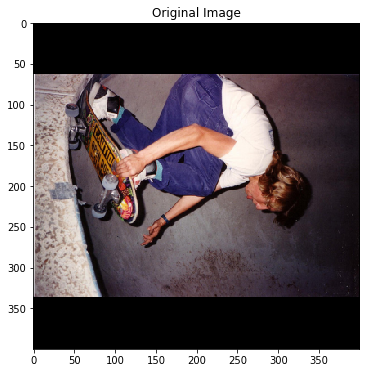

In [12]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
visualizations.visualize_image(np.array(imgs[0,:]), ax=ax, title="Original Image")

In [18]:
def multiscale_inference(model, imgs, scales, image_size, device):
    
    model.eval()
    
    batch_size = imgs.shape[0]
    avg_heatmaps = np.zeros((batch_size, 19, image_size, image_size), dtype=np.float32)
    avg_pafs = np.zeros((batch_size, 38, image_size, image_size), dtype=np.float32)
    avg_heatmaps = torch.Tensor(avg_heatmaps).to(device)
    avg_pafs = torch.Tensor(avg_pafs).to(device)
    
    for ratio in scales:
        
        scaled_img = F.interpolate(imgs, int(round(ratio*image_size)), mode="bilinear", align_corners=True)

        pred_pafs_stages, pred_hms_stages = model(scaled_img.to(device).float())

        scaled_pafs = F.interpolate(pred_pafs_stages.clone().detach(), image_size, mode="bilinear", align_corners=True).to(device)
        scaled_hms = F.interpolate(pred_hms_stages.clone().detach(), image_size, mode="bilinear", align_corners=True).to(device)
        
        avg_heatmaps += scaled_hms
        avg_pafs += scaled_pafs
    
    avg_heatmaps = avg_heatmaps/len(scales)
    avg_pafs = avg_pafs/len(scales)
    
    return avg_heatmaps, avg_pafs


In [19]:
scales = [0.5, 1.0, 1.5, 2.0]
scaled_hms, scaled_pafs = multiscale_inference(model, imgs, scales, image_size, device)

torch.Size([1, 38, 25, 25])
torch.Size([1, 19, 25, 25])


torch.Size([1, 38, 50, 50])
torch.Size([1, 19, 50, 50])


torch.Size([1, 38, 75, 75])
torch.Size([1, 19, 75, 75])


torch.Size([1, 38, 100, 100])
torch.Size([1, 19, 100, 100])




In [ ]:
print(scaled_hms.shape)
print(scaled_pafs.shape)

In [ ]:
scaled_hms = np.array(scaled_hms[0,:].cpu())
scaled_pafs = np.array(scaled_pafs[0,:].cpu())

In [ ]:
IDX_TO_KPT_NAME = {0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear',
                   5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow',
                   9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip',
                   13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle', 17:"all"}

In [ ]:
plt.figure(figsize=(40,30))
for i in range(18):
    plt.subplot(4,5,i+1)
    ax = plt.gca()
    title = f"Keypoint Label: {IDX_TO_KPT_NAME[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(heatmaps[0,i,:]), img=np.array(imgs[0,:]), ax=ax, title=title)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(40,30))
for i in range(18):
    plt.subplot(4,5,i+1)
    ax = plt.gca()
    title = f"Keypoint Pred: {IDX_TO_KPT_NAME[i]}"
    visualizations.overlay_heatmap(heatmap=scaled_hms[i,:], img=np.array(imgs[0,:]), ax=ax, title=title)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(40,60))
for i in range(23):
    plt.subplot(6,5,i+1)
    ax = plt.gca()
    visualizations.overlay_paf(pafs=np.array(pafs[0,2*i:2*i+2,:]), img=np.array(imgs[0,:]), ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(40,60))
for i in range(23):
    plt.subplot(6,5,i+1)
    ax = plt.gca()
    visualizations.overlay_paf(pafs=scaled_pafs[2*i:2*i+2,:], img=np.array(imgs[0,:]), ax=ax)
plt.tight_layout()
plt.show()

## Grouping and Skeleton Rendering

In [ ]:
cur_img = np.array(imgs[0,:])

In [ ]:
coords_1, keypoints_1 = pose_parsing.extract_joins_heatmap(heatmaps[0,:], min_distance=1, thr=0.5)
coords_2, keypoints_2 = pose_parsing.extract_joins_heatmap(scaled_hms, min_distance=1, thr=0.5)

In [ ]:
plt.figure(figsize=(32, 18))
zoom = 4

aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, keypoint in enumerate(keypoints_1):
    
    aux = np.copy(aux_img)
    if(len(keypoint) > 0):
        for k in keypoint:
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {IDX_TO_KPT_NAME[i]}")
    
plt.suptitle("Joints Extracted From Labels")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(32, 18))
zoom = 4

aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, keypoint in enumerate(keypoints_2):
    
    aux = np.copy(aux_img)
    if(len(keypoint) > 0):
        for k in keypoint:
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
            aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {IDX_TO_KPT_NAME[i]}")
    
plt.suptitle("Joints Extracted From Detections")
plt.tight_layout()
plt.show()

In [ ]:
pose_parsing.BODY_PARTS_PAF_IDS = CONSTANTS.BODY_PARTS_PAF_IDS_OPEN_POSE_VGG
pose_parsing.SKELETON = CONSTANTS.SKELETON_OPEN_POSE_VGG

In [ ]:
pose_entries, all_keypoints = pose_parsing.group_keypoints(keypoints_1, pafs[0,:], min_paf_score=0.05, thr_ratio=0.8)

In [ ]:
# pose_entries_det, all_keypoints_det = pose_parsing.group_keypoints(keypoints_2, scaled_pafs, min_paf_score=0.05, thr_ratio=0.8)
pose_entries_det, all_keypoints_det, pose_entries_det_aux = pose_parsing.group_keypoints(keypoints_2, scaled_pafs, min_paf_score=0.05, thr_ratio=0.8, debug=True)

In [ ]:
print(len(pose_entries))
print(len(pose_entries_det))
print(len(pose_entries_det_aux))

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
ax = plt.gca()
title = "Pose from Labels"
visualizations.draw_pose(cur_img, pose_entries, all_keypoints, ax=ax, title=title)

plt.subplot(1,2,2)
ax = plt.gca()
title = "Predicted Poses"
visualizations.draw_pose(cur_img, pose_entries_det, all_keypoints_det, ax=ax, title=title)


plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(60, 60))

for i in range(len(pose_entries)):
    plt.subplot(7,4,i+1)
    ax = plt.gca()
    title = f"Pose {i+1}"
    visualizations.draw_pose(cur_img, [pose_entries[i]], all_keypoints, ax=ax, title=title)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(60, 60))

for i in range(len(pose_entries_det)):
    plt.subplot(7,4,i+1)
    ax = plt.gca()
    title = f"Pose {i+1}"
    visualizations.draw_pose(cur_img, [pose_entries_det[i]], all_keypoints_det, ax=ax, title=title)
    print(pose_entries_det[i][-1])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(60, 60))

for i in range(len(pose_entries_det_aux)):
    plt.subplot(7,4,i+1)
    ax = plt.gca()
    title = f"Pose {i+1}"
    visualizations.draw_pose(cur_img, [pose_entries_det_aux[i]], all_keypoints_det, ax=ax, title=title)
    print(pose_entries_det_aux[i][-1])
plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
print(scaled_hms.shape)
print(scaled_pafs.shape)
print(metadata)

In [ ]:
# computing predictions, loading previous results and appending new ones
utils.reset_predictions_file(test_exp)
cur_predictions = metrics.compute_predictions(scaled_hms, scaled_pafs, metadata, cur_size=image_size)
# cur_predictions = metrics.compute_predictions(np.array(heatmaps[0,:]), np.array(pafs[0,:]), metadata, cur_size=image_size)
utils.update_predictions_file(cur_predictions, test_exp)

In [ ]:
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [ ]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

In [ ]:
pose_parsing.BODY_PARTS_PAF_IDS = CONSTANTS.BODY_PARTS_PAF_IDS_OPEN_POSE_VGG
pose_parsing.SKELETON = CONSTANTS.SKELETON_OPEN_POSE_VGG

In [ ]:
cur_predictions_pred = metrics.compute_predictions(scaled_hms, scaled_pafs, metadata, cur_size=image_size)
cur_predictions_lbls = metrics.compute_predictions(np.array(heatmaps[0,:]), np.array(pafs[0,:]), metadata, cur_size=image_size)